In [1]:
!pwd
save = True

/lustrehome/mbuonsante/B_4mu/CMSSW_13_0_13/src/XGBoost


In [ ]:
import sys, os, subprocess, json, pickle, uproot
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from xgboost import XGBRegressor, plot_importance
import mplhep as hep

from matplotlib import pyplot as plt

#Only on RECAS JupyterLab Service
os.environ['PATH'] += ':/lustrehome/mbuonsante/miniconda3/envs/root_env/bin' #Only on RECAS JupyterLab Service 
from ROOT import RDF

In [3]:
def get_arrays(tree, branch_list):
    _dict = {}
    for _br in branch_list:
        _dict[_br] = getattr(tree[_br].arrays(), _br)
    return pd.DataFrame.from_dict(_dict)

def get_input_features(df, train_list, cuts=''):
    if cuts=='': return df[train_list].to_numpy()
    _df = df[df.eval(cuts)]
    return _df[train_list].to_numpy()

def plot_training_history(model, category, fold, metric):    
    results = model.evals_result()
    epochs = len(results['validation_0'][metric])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots(figsize=(6.6,4.4))
    ax.plot(x_axis, results['validation_0'][metric], label='Train')
    ax.plot(x_axis, results['validation_1'][metric], label='Test')
    ax.legend(fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.title('{} (iFold={})'.format(category, fold), fontsize=16)
    plt.show()
    fig.savefig(out_dir+"/AUC_plot_"+category+"fold_"+str(fold)+".png")

def load_pkl(fname):
    with open(fname, 'rb') as f:
        obj = pickle.load(f)
    return obj

def get_parameters(json_file, cat):
    """Get parameters for XGBoost"""
    parameters = json_file["xgb_parameters_"+cat]
    param = {}
    for entry in parameters:
        key = list(entry.keys())[0]
        value = entry[key]
        param[key] = value
    return param

In [4]:
# Open config File
config = "config.json"
with open(config, 'r') as file:
    json_file_temp = json.load(file)
    
output_folder = json_file_temp['output_folder']
try:
    label = json_file_temp['label']
except KeyError:
    label = ""

In [5]:
# Create new config File
date = datetime.now().strftime("%Y%m%d-%H%M%S")
out_dir = output_folder+"/"+label+"_"+date
if not os.path.exists(out_dir):
    subprocess.call("mkdir -p %s" % out_dir, shell=True)
config_out = out_dir+"/config.json"
json_file_temp["date"] = date
with open(config_out, 'w') as file:
    json.dump(json_file_temp, file, indent=2)

In [6]:
# Open new config File
with open(config_out, 'r') as file:
    json_file = json.load(file)

categories_list = json_file["categories"]
param = []
for c in categories_list:
    param_temp = get_parameters(json_file, c)
    param.append(param_temp)

In [7]:
# load data
input_files = json_file['input_files']
training_variables = json_file['training_variables']
spectator_variables = json_file['spectator_variables']
tree_name = json_file['tree_name']
final_cut = json_file['final_cut']
dfs = []
for file in input_files:
    print("Loading data from ", file)
    file_temp = uproot.open(file)
    df_temp = get_arrays(file_temp[tree_name], training_variables+spectator_variables)
    dfs.append(df_temp)
df = pd.concat(dfs)
df = df.reset_index(drop=True)
del dfs

Loading data from  ../Utilities_organized/ROOTFiles_04_09_24/AllData2022.root
Loading data from  ../Utilities_organized/ROOTFiles_04_09_24/AllData2023.root


In [8]:
print(df['isMC'].unique())
df['isMC'] = df['isMC'].clip(lower=0)
print(df['isMC'].unique())

[1 2 0]
[1 2 0]


In [9]:
index_branch = [json_file['index_branch']]
kFolds = json_file['number_of_splits']
try:
    weight_column = [json_file['weight_column']]
except KeyError:
    weight_column = None
try:
    normalize_samples = json_file['normalize_samples']
except KeyError:
    normalize_samples = False
try:
    weight_scale = [json_file['weight_scale']]
except KeyError:
    weight_scale = 1
X_list = []
y_list = []
weight_train_list = []
kfold_split_list = []

print(categories_list)
for cat in categories_list:
    try:
        bkg_sel = json_file[cat+"_bkg"]
    except KeyError:
        bkg_sel = ""
    try:
        sig_sel = json_file[cat+"_sig"]
    except KeyError:
        sig_sel = ""
    X_bkg_temp = get_input_features(df, training_variables, bkg_sel)
    X_sig_temp = get_input_features(df, training_variables, sig_sel)
    
    y_bkg_temp = np.zeros(len(X_bkg_temp))
    y_sig_temp = np.ones(len(X_sig_temp))
    
    bkg_eventNumber = get_input_features(df, index_branch, bkg_sel)
    sig_eventNumber = get_input_features(df, index_branch, sig_sel)

    if weight_column is not None:
        W_bkg_temp = get_input_features(df, weight_column, bkg_sel)
        W_sig_temp = get_input_features(df, weight_column, sig_sel)
        W_sig_temp = W_sig_temp*weight_scale
        if normalize_samples:
            W_sig_temp = W_sig_temp*len(W_bkg_temp)/len(W_sig_temp)
            
        weight_train_list.append(np.concatenate((W_bkg_temp, W_sig_temp)))

    X_list.append(np.concatenate((X_bkg_temp, X_sig_temp)))
    y_list.append(np.concatenate((y_bkg_temp, y_sig_temp)))
    kfold_split_list.append(np.concatenate((bkg_eventNumber % kFolds, sig_eventNumber % kFolds)))


['Cat']


In [10]:
xgbcvclassifiers = {cat: [] for cat in categories_list}
print(xgbcvclassifiers)

{'Cat': []}


In [11]:
# fit models 
number_of_training = kFolds*len(categories_list)
with tqdm(total=number_of_training, desc="Training... ", bar_format="{desc}: {percentage:.0f}%|{bar:80}| {n}/{total} ") as progress_bar:
    for catID in range(len(categories_list)):
        for ifold in range(kFolds):
            X_train = X_list[catID][kfold_split_list[catID].flatten()!=ifold,:]
            Y_train = y_list[catID][kfold_split_list[catID].flatten()!=ifold]
            if weight_column is not None: 
                weights_train = weight_train_list[catID][kfold_split_list[catID].flatten()!=ifold]
            
            X_test = X_list[catID][kfold_split_list[catID].flatten()==ifold,:]
            Y_test = y_list[catID][kfold_split_list[catID].flatten()==ifold]
            
            model = XGBRegressor(**param[catID])
            #model = XGBClassifier(**param[catID])

            if weight_column is not None:
                history = model.fit(X_train, Y_train,
                                    verbose               = 0,
                                    sample_weight = weights_train,
                                    eval_set=[(X_train, Y_train), (X_test, Y_test)]
                                   )
            else:
                history = model.fit(X_train, Y_train,
                                    verbose               = 0,
                                    eval_set=[(X_train, Y_train), (X_test, Y_test)]
                                   )
            
            xgbcvclassifiers[categories_list[catID]].append((model, history))
            #save model
            pickle.dump(model, open(out_dir+"/model_"+categories_list[catID]+"_fold"+str(ifold)+".pkl", "wb"))
            progress_bar.update(1)

Training... : 100%|████████████████████████████████████████████████████████████████████████████████| 10/10 


In [12]:
df["kfoldID"] = (df[index_branch] % kFolds).astype(int)
all_input_X = get_input_features(df, training_variables, '')
try:
    category_branch = json_file["category_branch"]
except KeyError:
    category_branch = "NO_category_temp"

if(len(categories_list)==1 and category_branch == "NO_category_temp"):
    df[category_branch] = 0

bdt_scores = (df[category_branch]==0).to_numpy()*(0.0)
bdt_cv_scores = (df[category_branch]==0).to_numpy()*(0.0)
folds = []
for k in range(kFolds):
    folds.append((df[category_branch]==0).to_numpy()*(0.0))
    
for ic, category_ in enumerate(xgbcvclassifiers):
    for fold_ in range(kFolds):
        all_tmpscores = xgbcvclassifiers[category_][fold_][0].predict(all_input_X)
        #all_tmpscores = xgbcvclassifiers[category_][fold_][0].predict_proba(all_input_X)[:, 1]
        bdt_scores += ((df[category_branch]==(ic)).to_numpy()*all_tmpscores)/kFolds
        folds[fold_] += (df[category_branch]==(ic)).to_numpy()*all_tmpscores 
        bdt_cv_scores += ((df[category_branch]==(ic)) & (df["kfoldID"]==(fold_)) ).to_numpy()*all_tmpscores 

df['bdt'] = bdt_scores
df['bdt_cv'] = bdt_cv_scores
bdt_folds = []
for k in range(kFolds):
    branch_name_temp = f"bdt_fold{k}"
    bdt_folds.append(branch_name_temp)
    df[branch_name_temp] = folds[k]

/lustrehome/mbuonsante/miniconda3/envs/root_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:40:29] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [13]:
#df['bdt_cv_2'] = 1 - np.log2(2 -(1 - np.log2(2 -(1 - np.log2(2 -(1 - np.log2(2 - (1 - np.log2(2 - (1 - np.log2(2 - (1 - np.log2(2 - df['bdt_cv'])))))))))))))
df = df[df.eval(final_cut)]

In [14]:
fileName = out_dir+"/TrainedDataset_"+date
if save==True:  
    df.to_csv(fileName+".csv", index=False)

In [15]:
if save==True:  
    rdf = RDF.FromCSV(fileName+".csv")
    #rdf = RDF.MakeCsvDataFrame(fileName+".csv")
    rdf.Snapshot("OutputTree", fileName+".root")

## Plots:

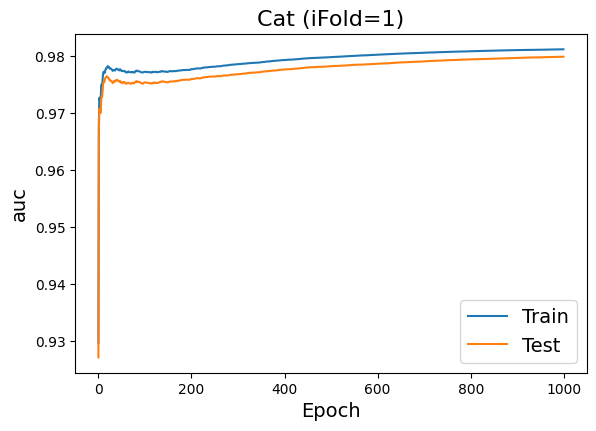

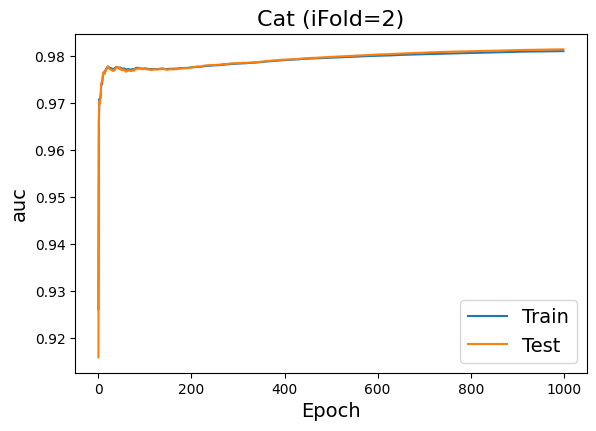

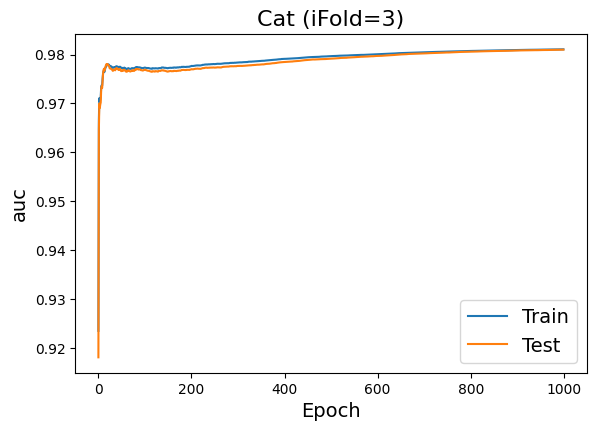

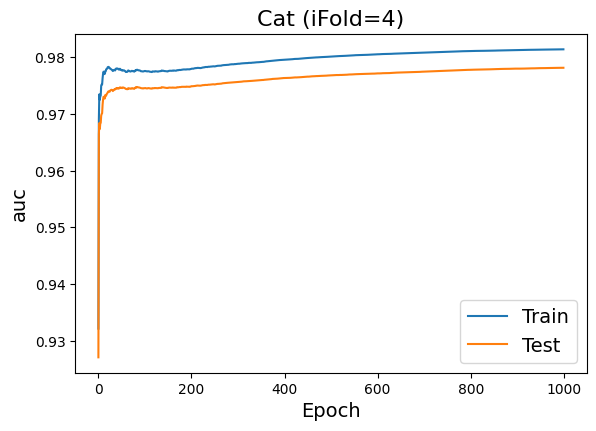

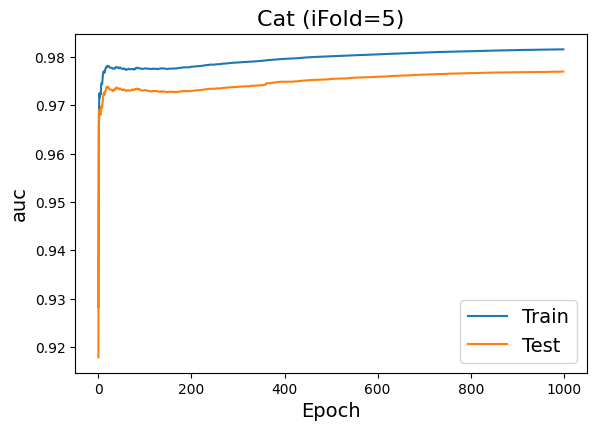

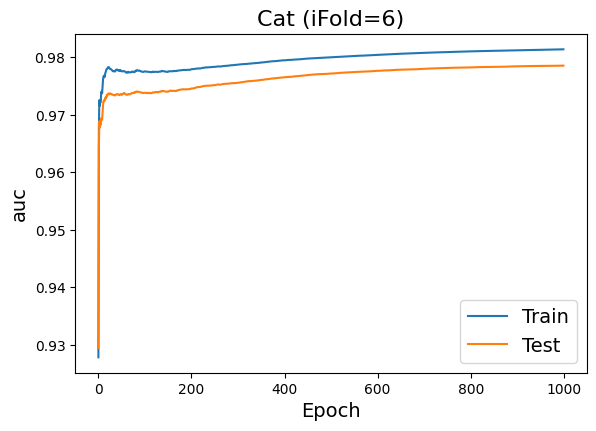

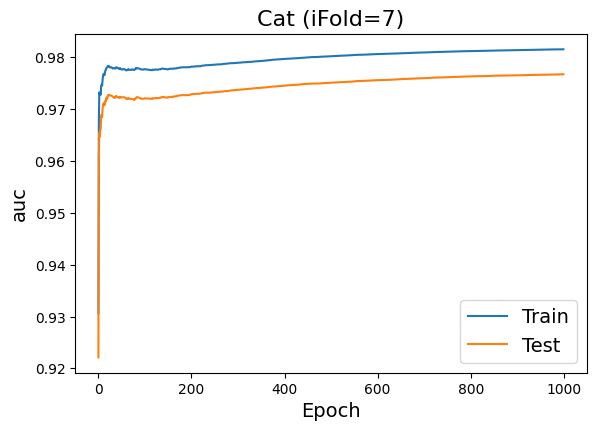

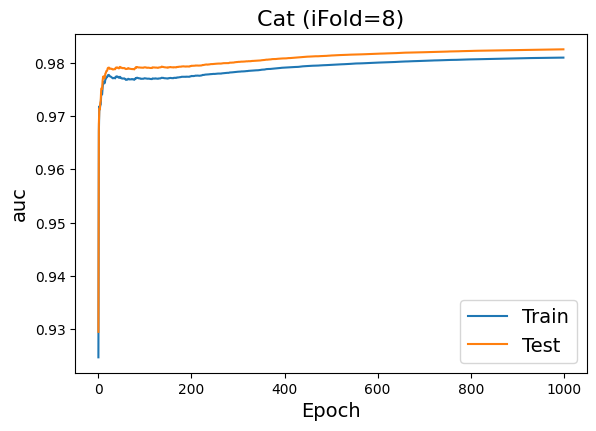

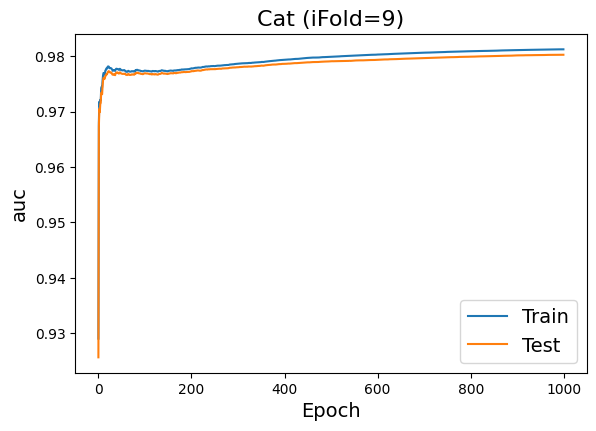

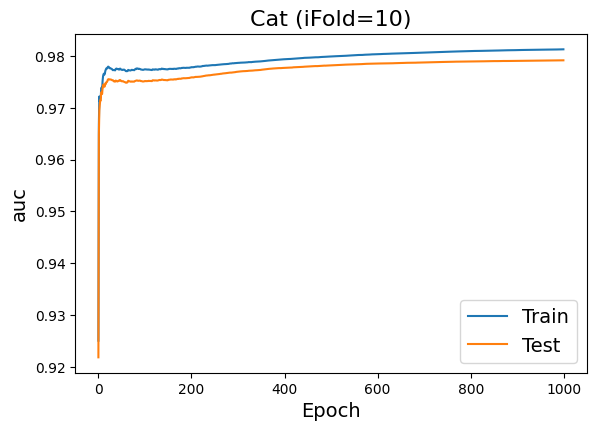

In [16]:
for category_ in xgbcvclassifiers:
    for fold_ in range(kFolds):
        plot_training_history(xgbcvclassifiers[category_][fold_][0], category_, fold_+1, param[0]["eval_metric"])

In [17]:
plt.style.use(hep.style.CMS)
signal_sel = "isMC>0 & JPsicut==1 & Phicut==1 & Omegacut==1 & Psi2scut==1"
bkg_sel = "(((Quadruplet_Mass-5.366)>0.2) | ((Quadruplet_Mass-5.277)<0.2)) & (isMC==0) & JPsicut==1 & Phicut==1 & Omegacut==1 & Psi2scut==1"

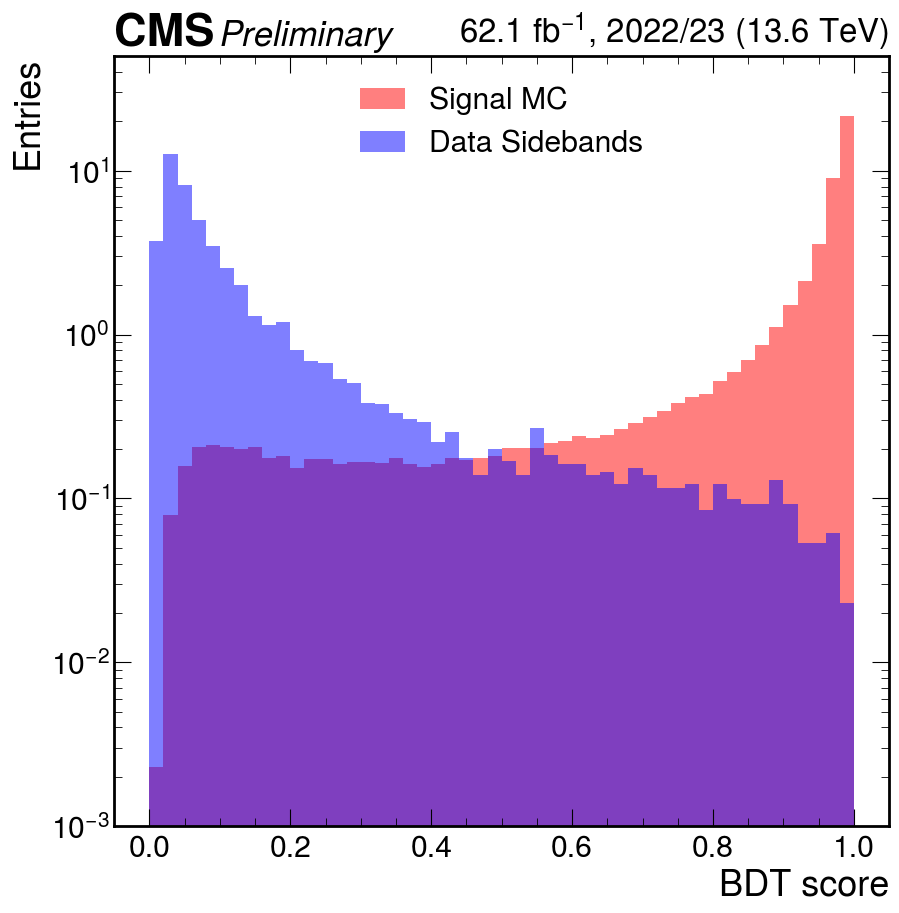

In [24]:
bins=50
fig, ax = plt.subplots()
hep.cms.label(data=True, label="Preliminary", loc=0, year="2022/23", lumi=62.1, com=13.6, lumi_format="{0:.1f}", fontsize=25);
hep.histplot(np.histogram(df[df.eval(signal_sel)]["bdt_cv"].to_numpy(), bins=bins, range=(0,1)),  density=True, histtype="fill", label="Signal MC", alpha=0.5, color='red');
hep.histplot(np.histogram(df[df.eval(bkg_sel)]["bdt_cv"].to_numpy(), bins=bins, range=(0,1)), density=True, histtype="fill", label="Data Sidebands", alpha=0.5, color='blue');
ax.set_xlabel("BDT score")
ax.set_ylabel("Entries")
ax.set_yscale('log')
ax.legend(loc='upper center')
ax.set_ylim(1e-3, 50)
plt.show()
#plt.savefig(out_dir+"/BDT_score.png", dpi=300, bbox_inches='tight')

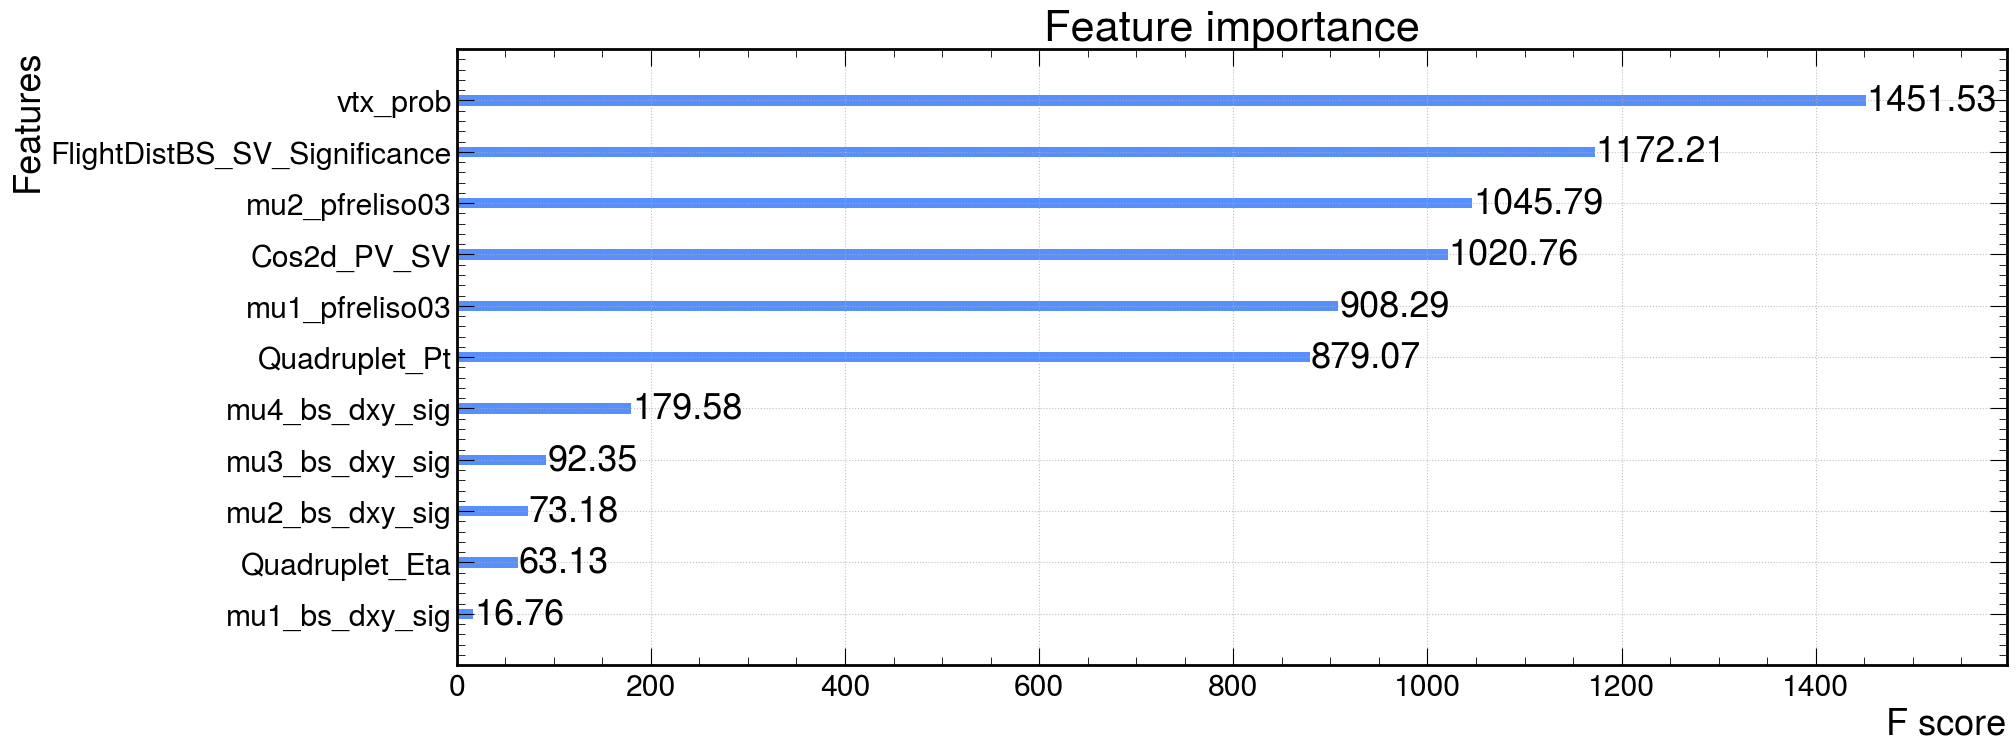

In [19]:
#importance "weight"  or "gain"
#feature importance
for category_ in xgbcvclassifiers:
    importance = []
    for fold_ in range(kFolds):
        # Get the booster from the xgbmodel
        booster = xgbcvclassifiers[category_][fold_][0].get_booster()
        booster.feature_names = training_variables
    
        # Get the importance dictionary (by gain) from the booster
        importance_temp = booster.get_score(importance_type="weight")

        # make your changes
        for key in importance_temp.keys():
            importance_temp[key] = round(importance_temp[key],2)
        importance.append(importance_temp)

    #average importance across different folds
    importance_avg = importance[2]

    for key in importance_avg.keys():
        importance_avg[key]=0
        for fold_ in range(kFolds):
            try:
                importance_avg[key] += importance[fold_][key]/kFolds
            except:
                importance_avg[key] += 0
        importance_avg[key] = round(importance_avg[key],2)
    
    # provide the importance dictionary to the plotting function
    ax = plot_importance(importance_avg, max_num_features=30, importance_type='gain', show_values=True)

    fig = ax.figure
    fig.set_size_inches(20, 8)
    fig.savefig(out_dir+"/feature_importance_"+category_+".png")

KeyboardInterrupt: 

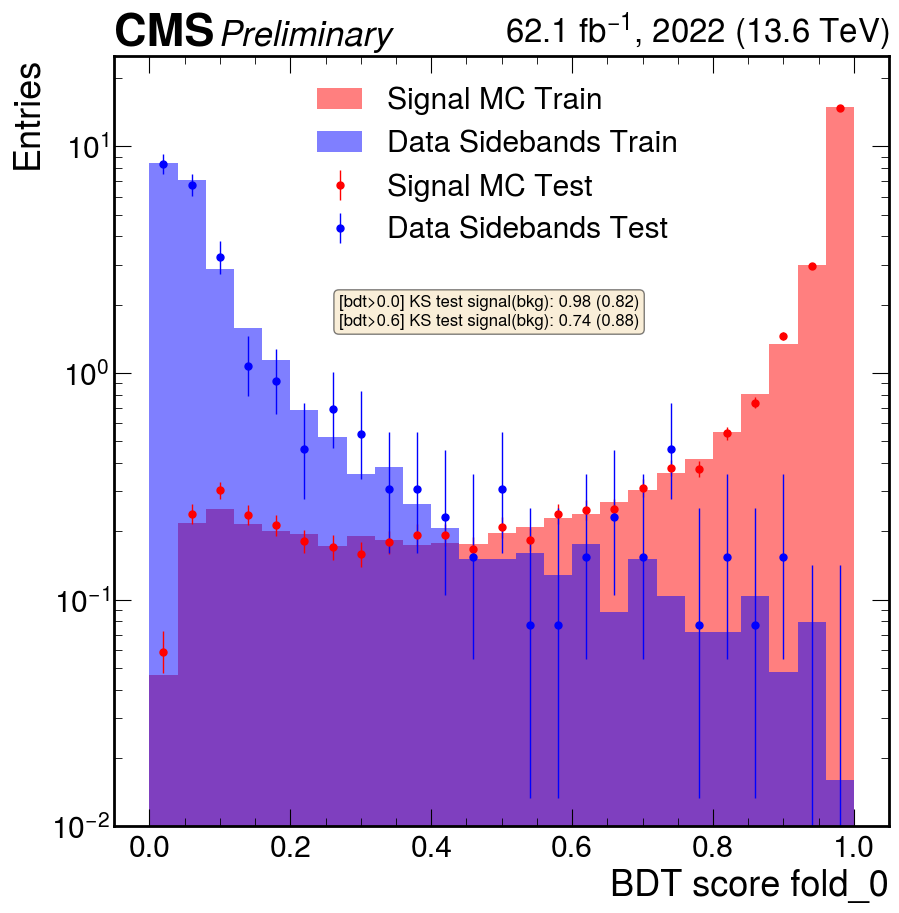

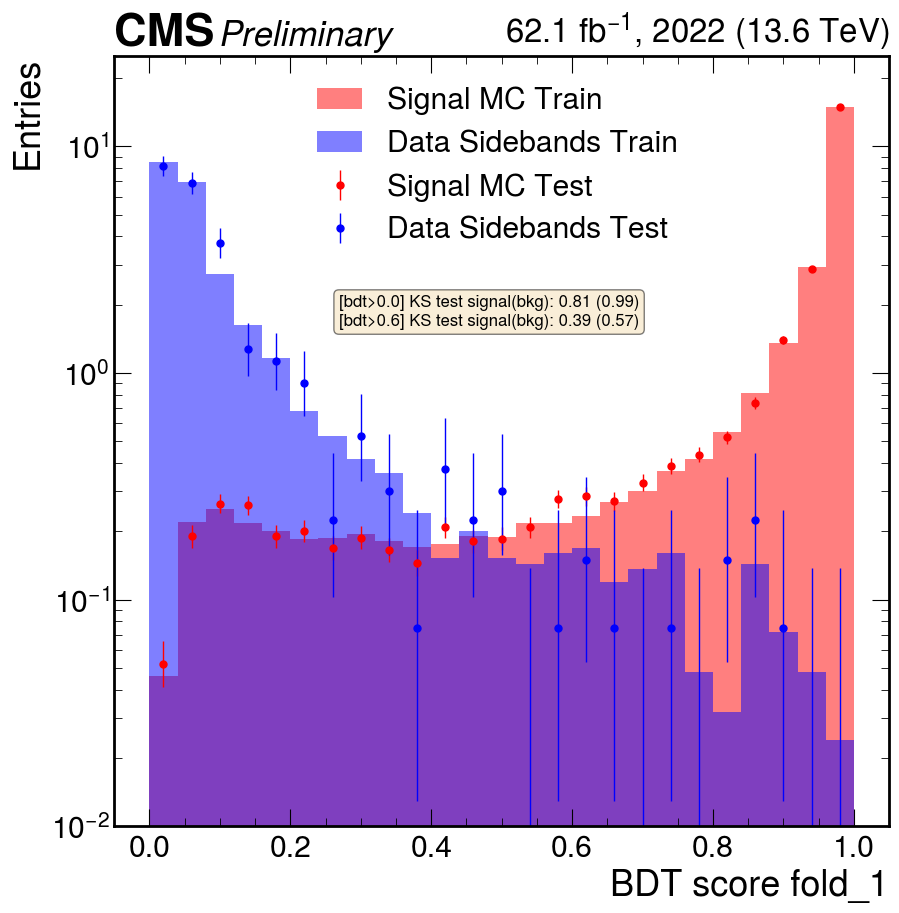

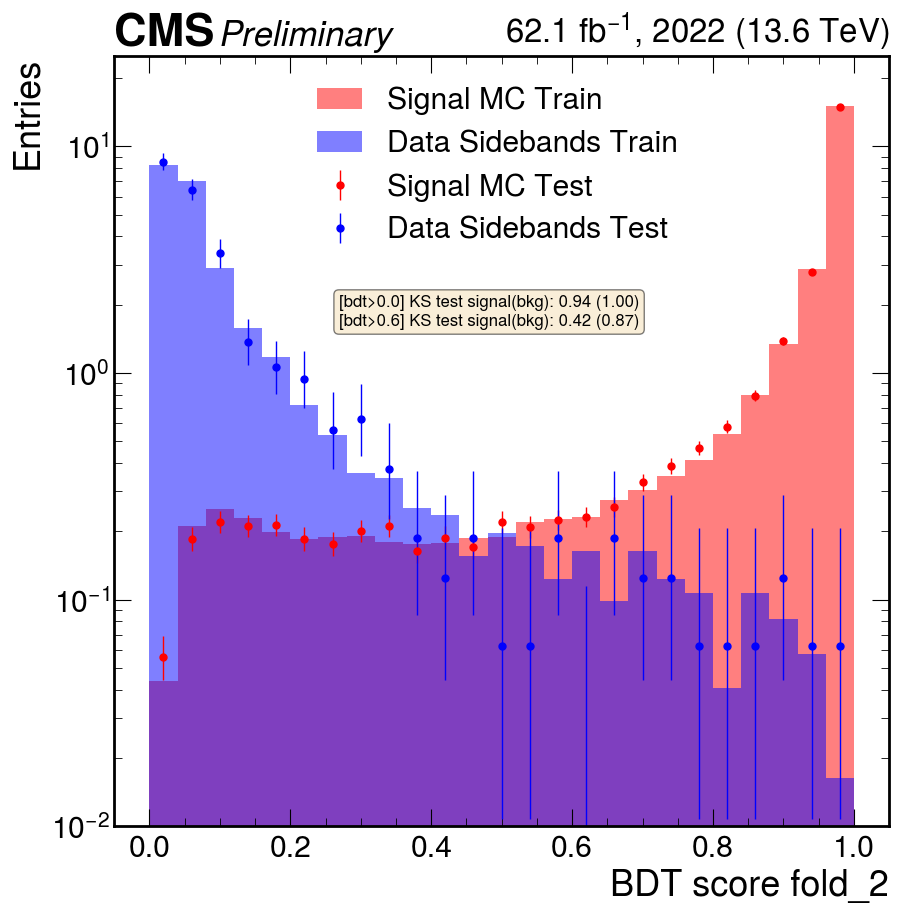

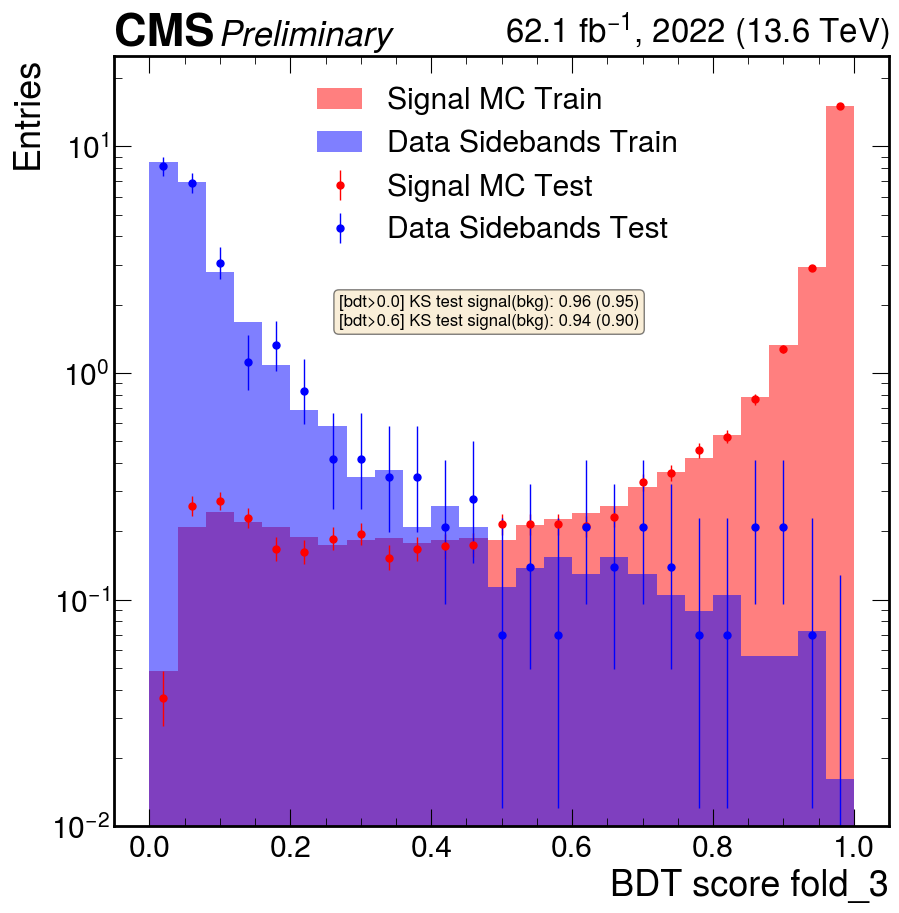

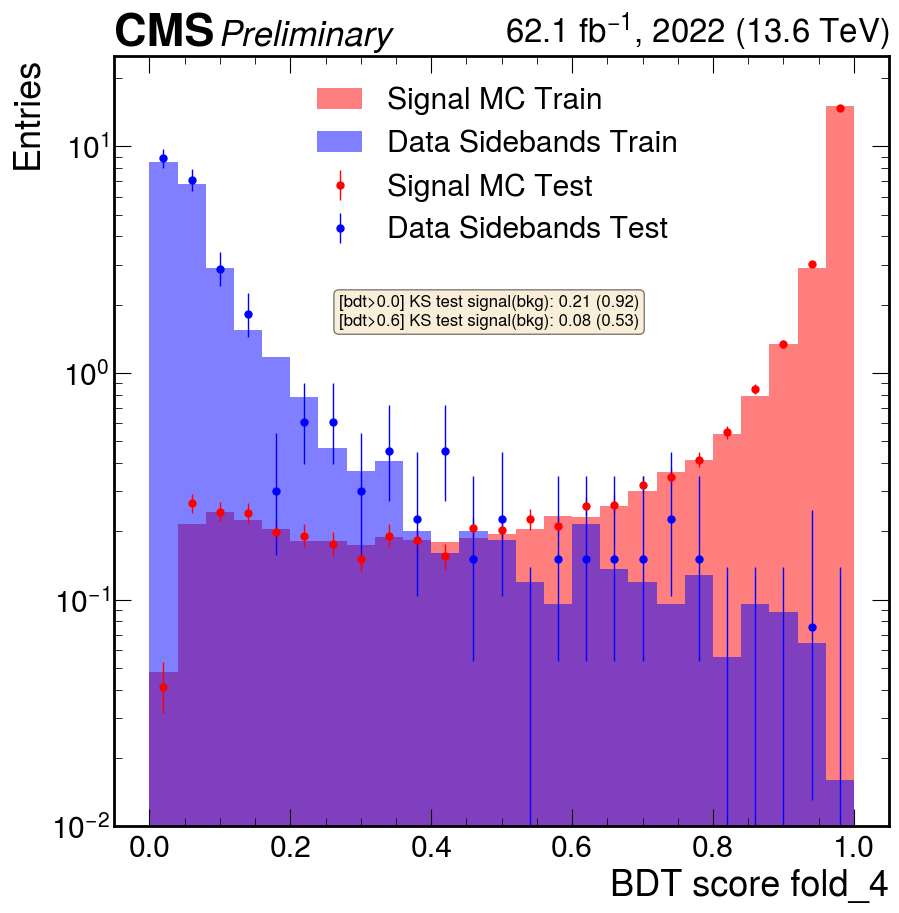

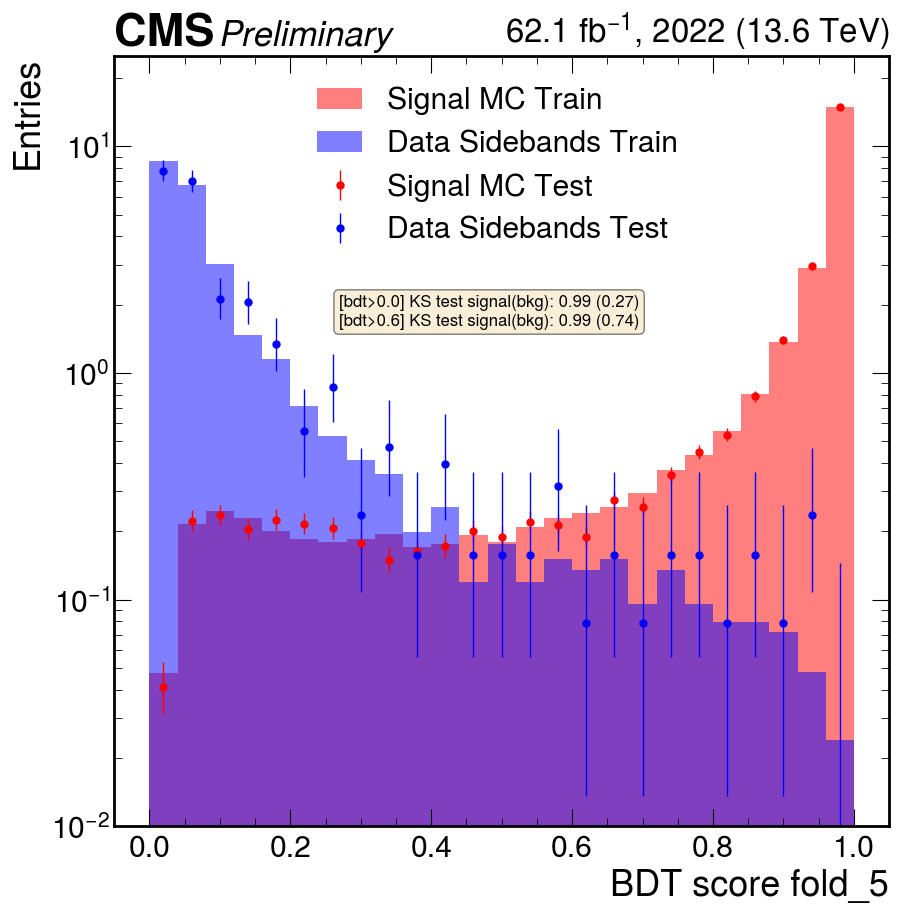

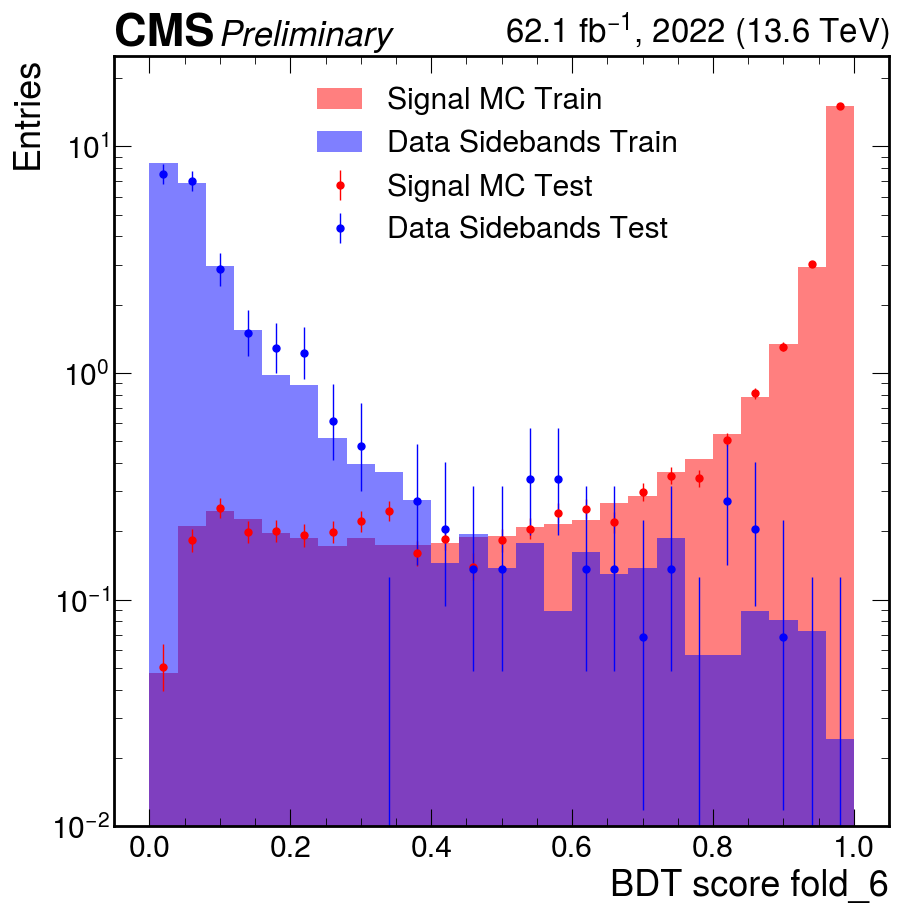

In [20]:
if save==True:  
    bins = 25
    for year in ["2022", "2023"]:
        for fold_ in range(kFolds):
            fig, ax = plt.subplots()
            hep.cms.label(data=True, label="Preliminary", loc=0, year=year, lumi=62.1, com=13.6, lumi_format="{0:.1f}", fontsize=25);
            testsel = f"& kfoldID == {fold_}"
            trainsel = f"& kfoldID != {fold_}"
            year_sel = "& year=="+year
            SignalTrain = df[df.eval(signal_sel+trainsel+year_sel)][f"bdt_fold{fold_}"].to_numpy()
            SignalTest = df[df.eval(signal_sel+testsel+year_sel)][f"bdt_fold{fold_}"].to_numpy()
            BkgTrain = df[df.eval(bkg_sel+trainsel+year_sel)][f"bdt_fold{fold_}"].to_numpy()
            BkgTest = df[df.eval(bkg_sel+testsel+year_sel)][f"bdt_fold{fold_}"].to_numpy()
            hep.histplot(np.histogram(SignalTrain, bins=bins, range=(0,1)), density=True, histtype="fill", label="Signal MC Train", alpha=0.5, color='red');
            hep.histplot(np.histogram(SignalTest, bins=bins, range=(0,1)), density=True, histtype="errorbar", label="Signal MC Test", color='red');
            hep.histplot(np.histogram(BkgTrain, bins=bins, range=(0,1)), density=True, histtype="fill", label="Data Sidebands Train ", alpha=0.5, color='blue');
            hep.histplot(np.histogram(BkgTest, bins=bins, range=(0,1)), density=True, histtype="errorbar", label="Data Sidebands Test", color='blue');
            ax.set_xlabel(f"BDT score fold_{fold_}")
            ax.set_ylabel("Entries")
            ax.set_yscale('log')
            ax.set_ylim(1e-2, 25)
            ax.legend(loc='upper center')
            hs1 = rdf.Filter(signal_sel+testsel+year_sel).Histo1D(("h1", "h1", bins, 0, 1), f"bdt_fold{fold_}").Clone()
            hs2 = rdf.Filter(signal_sel+trainsel+year_sel).Histo1D(("h2", "h2", bins, 0, 1), f"bdt_fold{fold_}").Clone()
            hs3 = rdf.Filter(signal_sel+testsel+year_sel+" & bdt_cv>0.6").Histo1D(("h3", "h3", bins, 0.6, 1), f"bdt_fold{fold_}").Clone()
            hs4 = rdf.Filter(signal_sel+trainsel+year_sel+" & bdt_cv>0.6").Histo1D(("h4", "h4", bins, 0.6, 1), f"bdt_fold{fold_}").Clone()
            
            hb1 = rdf.Filter(bkg_sel+testsel+year_sel).Histo1D(("b1", "b1", bins, 0, 1), f"bdt_fold{fold_}").Clone()
            hb2 = rdf.Filter(bkg_sel+trainsel+year_sel).Histo1D(("b2", "b2", bins, 0, 1), f"bdt_fold{fold_}").Clone()
            hb3 = rdf.Filter(bkg_sel+testsel+year_sel+" & bdt_cv>0.6").Histo1D(("b3", "b3", bins, 0.6, 1), f"bdt_fold{fold_}").Clone()
            hb4 = rdf.Filter(bkg_sel+trainsel+year_sel+" & bdt_cv>0.6").Histo1D(("b4", "b4", bins, 0.6, 1), f"bdt_fold{fold_}").Clone()

            textstr = f'[bdt>0.0] KS test signal(bkg): {hs2.KolmogorovTest(hs1):.2f} ({hb2.KolmogorovTest(hb1):.2f})\n[bdt>0.6] KS test signal(bkg): {hs4.KolmogorovTest(hs3):.2f} ({hb4.KolmogorovTest(hb3):.2f})'
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.29, 0.69, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
            plt.savefig(out_dir+"/BDT_score_"+year+"fold_"+str(fold_)+".png", dpi=300, bbox_inches='tight')
            #plt.show()
            del hs1
            del hs2
            del hs3
            del hs4
            del hb1
            del hb2
            del hb3
            del hb4        
